In [24]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import hdbscan 
from sklearn.cluster import DBSCAN
from datetime import datetime

In [25]:
# read data from csv file
fake_transaction = pd.read_csv('fake_transactional_data_24.csv')
# create new column 'weekday'
fake_transaction['weekday'] = fake_transaction['not_happened_yet_date'].apply(lambda x: datetime.strptime(x, "%d/%m/%Y").strftime("%A"))
fake_transaction_category = fake_transaction[fake_transaction['to_randomly_generated_account'].astype(str).str.isnumeric() == False]
fake_transaction_category

,from_totally_fake_account,monopoly_money_amount,to_randomly_generated_account,not_happened_yet_date,weekday
0,10371.0,4.00,CINEMA,01/01/2025,Wednesday
3,18555.0,4.10,HIPSTER_COFFEE_SHOP,01/01/2025,Wednesday
5,18555.0,4.45,TOTALLY_A_REAL_COFFEE_SHOP,01/01/2025,Wednesday
6,18555.0,1.45,COFFEE_SHOP,01/01/2025,Wednesday
7,18555.0,5.00,CAFE,01/01/2025,Wednesday
...,...,...,...,...,...
10148274,81404.0,1.80,TOTALLY_A_REAL_COFFEE_SHOP,31/12/2025,Wednesday
10148275,32185.0,2.65,COFFEE_SHOP,31/12/2025,Wednesday
10148276,32185.0,2.45,COFFEE_SHOP,31/12/2025,Wednesday
10148277,57569.0,14.00,WINE_BAR,31/12/2025,Wednesday


In [34]:
new_categories = pd.read_excel('/Users/blackrose/Desktop/dsmp-2024-group-38/finalised_merchant_categories.xlsx')

categories = new_categories.columns
category_account_pairs = []
for category in categories:
    businesses = new_categories[category].dropna().apply(lambda x: x.strip("'"))
    for business in businesses:
        category_account_pairs.append({'business': business, 'category': category})

category_df = pd.DataFrame(category_account_pairs)

In [35]:
category_df

,business,category
0,TOY_SHOP,Children
1,SCHOOL_SUPPLY_STORE,Children
2,KIDS_CLOTHING_SHOP,Children
3,KIDS_ACTIVITY_CENTRE,Children
4,CHILDRENDS_SHOP,Children
...,...,...
74,WHISKEY_SHOP,Alcohol Store
75,LIQUOR_STORE,Alcohol Store
76,WINE_CELLAR,Alcohol Store
77,GYM,Gym


In [56]:
per_category = fake_transaction_category.merge(category_df, left_on='to_randomly_generated_account', right_on='business', how='left')
per_category.drop(['business', 'to_randomly_generated_account', 'not_happened_yet_date'], axis=1, inplace=True)
per_category.weekday.unique()

array(['Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday',
       'Tuesday'], dtype=object)

In [51]:
print(per_category.columns)


Index(['from_totally_fake_account', 'monopoly_money_amount', 'weekday',
       'category'],
      dtype='object')


In [55]:
from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import MinMaxScaler

num_attributes = per_category[['monopoly_money_amount']]
cat_attributes = per_category[['weekday', 'category']]

#  standardize the numerical data
scaler = MinMaxScaler()
num_attributes_scaled = scaler.fit_transform(num_attributes)
num_attributes_scaled_df = pd.DataFrame(num_attributes_scaled, columns=['monopoly_money_amount'])
feature_for_week = pd.concat([num_attributes_scaled_df, cat_attributes], axis=1)
feature_for_week

,monopoly_money_amount,weekday,category
0,0.008541,Wednesday,Cinema
1,0.008876,Wednesday,Café
2,0.010049,Wednesday,Café
3,0.000000,Wednesday,Café
4,0.011891,Wednesday,Café
...,...,...,...
7615512,0.001172,Wednesday,Café
7615513,0.004019,Wednesday,Café
7615514,0.003350,Wednesday,Café
7615515,0.042037,Wednesday,Bar


In [72]:
# missing values
feature_for_week.isnull().sum()




monopoly_money_amount         0
weekday                       0
category                 121145
dtype: int64

In [73]:
# drop null
per_category_without_null = feature_for_week.dropna()
per_category_without_null

,monopoly_money_amount,weekday,category
0,0.008541,Wednesday,Cinema
1,0.008876,Wednesday,Café
2,0.010049,Wednesday,Café
3,0.000000,Wednesday,Café
4,0.011891,Wednesday,Café
...,...,...,...
7615512,0.001172,Wednesday,Café
7615513,0.004019,Wednesday,Café
7615514,0.003350,Wednesday,Café
7615515,0.042037,Wednesday,Bar


In [74]:
per_category_without_null.isnull().sum()

monopoly_money_amount    0
weekday                  0
category                 0
dtype: int64

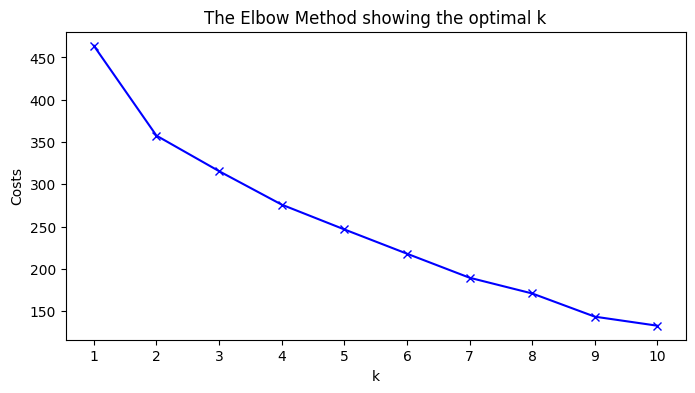

In [76]:
costs = []
# random sample 8000 rows 
per_category_sample = per_category_without_null.sample(n=8000, random_state=10)

K = range(1, 11)
for k in K:
    kproto = KPrototypes(n_clusters=k, random_state=10, init="Cao")
    kproto.fit_predict(per_category_sample, categorical= [1,2])
    costs.append(kproto.cost_)
    
plt.figure(figsize=(8, 4))
plt.plot(K, costs, 'bx-')
plt.xlabel('k')
plt.ylabel('Costs')
plt.title('The Elbow Method showing the optimal k')
plt.xticks(K)
plt.show()

In [81]:
kproto_clusters=KPrototypes(n_clusters=3,random_state=10,init="Cao")
result=kproto_clusters.fit_predict(per_category_sample,categorical=[1,2])

# numerical features from per_category_sample
numerical_features = per_category_sample.drop(columns=['weekday', 'category'])

# evaluate
silhouette_avg = silhouette_score(numerical_features, result, sample_size=8000)
print("Silhouette Score:", silhouette_avg)


Silhouette Score: 0.34229586085627184
